This is based on a fork. Original work is found: [here](https://www.kaggle.com/code/okcho9807/cyclegan-jy-zhu-et-al-2020])
# Introduction and Setup

# <span style="color:blue"> Coursera course: Introduction to Deep Learning </span>
## Week 5 assignment:  Cycle GAN for monet painting

# <span style="color:green"> Monet Painting Dataset - Use GANs to create art </span>
### University of Colorado Boulder
### Taught by:Geena Kim , Assistant Teaching
### <span style="color:gray">Solution by: Miguel Duque B.</span> 
Date: August, 2023


# Table of contents
* [1. Brief description of the problem and data](#section1)
* [2. Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data](#section2)
* [3. Model Building and Training](#section3)
* [4. Result](#section4)
* [5. Conclusion](#section5)

<a id='section1'></a>

# 1. Brief description of the problem and data

## Problem

This is a kaggle competition called [I’m Something of a Painter Myself](https://www.kaggle.com/competitions/gan-getting-started/overview).

In this competition, we are given two sets of images. One set is made of real photos, and the other is made of monet paintings. The task is to generate 10.000 images in monet style. In this notebook, this is done using  Generative adversarial network (GAN) called a cyclegan. 

You can read more about the architecture of a cyclegan here: [What is CycleGAN?](https://www.kaggle.com/code/dimitreoliveira/introduction-to-cyclegan-monet-paintings)

From the authors:

> We present an approach for learning to translate an image from a source domain X to a target domain Y in the absence of paired examples. Our goal is to learn a mapping G: X → Y, such that the distribution of images from G(X) is indistinguishable from the distribution Y using an adversarial loss. Because this mapping is highly under-constrained, we couple it with an inverse mapping F: Y → X and introduce a cycle consistency loss to push F(G(X)) ≈ X (and vice versa).

In essence it maps and image to a given domain, if you are turning horses into zebra the image will be the horse and the domain is the zebras, in our case the photos are the image and the domain are the Monet paintings.


## Data
The dataset contains four directories: monet_tfrec, photo_tfrec, monet_jpg, and photo_jpg. The monet_tfrec and monet_jpg directories contain the same painting images, and the photo_tfrec and photo_jpg directories contain the same photos.

## Instructions about the data.

It is recommended to use TFRecords to become familiar with this newer format.

The monet directories contain Monet paintings, to be used for training.

The photo directories contain photos. Add Monet-style to these images and submit your generated jpeg images as a zip file. Other photos outside of this dataset can be transformed but keep your submission file limited to 10,000 images.

Note: Monet-style art can be created from scratch using other GAN architectures like DCGAN. The submitted image files do not necessarily have to be transformed photos.

## Scoring
The quality of the set of 7.000 to 10.000 generated images is assesses through a MiFID or [Memorization-informed Fréchet Inception Distance](https://www.kaggle.com/competitions/gan-getting-started/overview/evaluation), which is a modification from Fréchet Inception Distance (FID). A smaller distance means a higher quality, and the leaderboard for this competition currently has 34.5 as top score.

## Structure and dimensions of the data

* All images are RGB images 256x256x3.
* There 300 Monet paintings and 7038 photos (this is computed below). Image augmentation techniques can be helpful.
* For convenience, the images are stored as float32 and they should be mapped to [-1,1]

## About the model
CycleGan achieves image to image translation without using paired images as input data.

**Original Cylcle GAN paper from 2017 and git hub repository:**
* [Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks](https://junyanz.github.io/CycleGAN/)
* [Git Hub](https://github.com/junyanz/CycleGAN)

The Cycle GAN model should contain 4 submodels:
* A generator that can generate monet images
* A generator that can generate photo images
* A discriminator that can identify real monet images
* A discriminator that can identify real photo images

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.utils import plot_model

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Number of replicas: 1
2.6.2


<a id='section2'></a>

# 2. Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

## Load in the data

We want to keep our photo dataset and our Monet dataset separate. First, load in the filenames of the TFRecords.

In [2]:
GCS_PATH = KaggleDatasets().get_gcs_path('gan-getting-started')

MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


All the images for the competition are already sized to 256x256. As these images are RGB images, set the channel to 3. Additionally, we need to scale the images to a [-1, 1] scale. Because we are building a generative model, we don't need the labels or the image id so we'll only return the image from the TFRecord.

In [3]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

Define the function to extract the image from the files.

In [4]:
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

Let's load in our datasets.

In [5]:
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

In [6]:
# Number of monet paintings and photos
len_monet = np.sum([len(p) for p in monet_ds])
len_photo = np.sum([len(p) for p in photo_ds])

In [7]:
print('The dataset contains:\n {} Monet paintings. \n {} photos.'.format(len_monet,len_photo))

The dataset contains:
 300 Monet paintings. 
 7038 photos.


## Inspect some random images

In [8]:
def display_samples(ds, row=3, col=3, title = 'samples', randomize = True):
    # Display an array of images from dataset
    # ds is of type: tensorflow.python.data.ops.dataset_ops.BatchDataset    
    if randomize:
        ds_iter =iter(ds.shuffle(buffer_size=1000)) # random sample
    else:
        ds_iter =iter(ds) # random sample
    plt.figure(figsize=(15, int(15*row/col)))
    for j in range(row*col):
        example_sample = next(ds_iter)
        plt.subplot(row,col,j+1)
        plt.axis('off')
        plt.imshow(example_sample[0] * 0.5 + 0.5)
        plt.suptitle(title, size=20)
    plt.show()

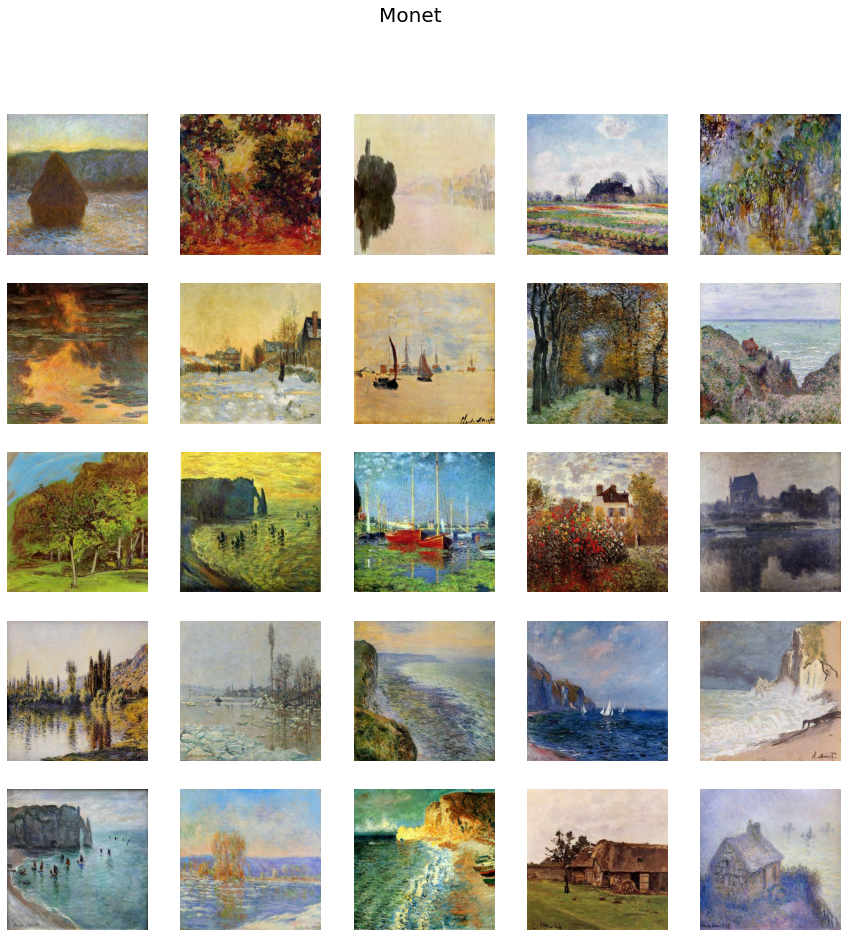

In [9]:
display_samples(monet_ds,5,5,'Monet',True)

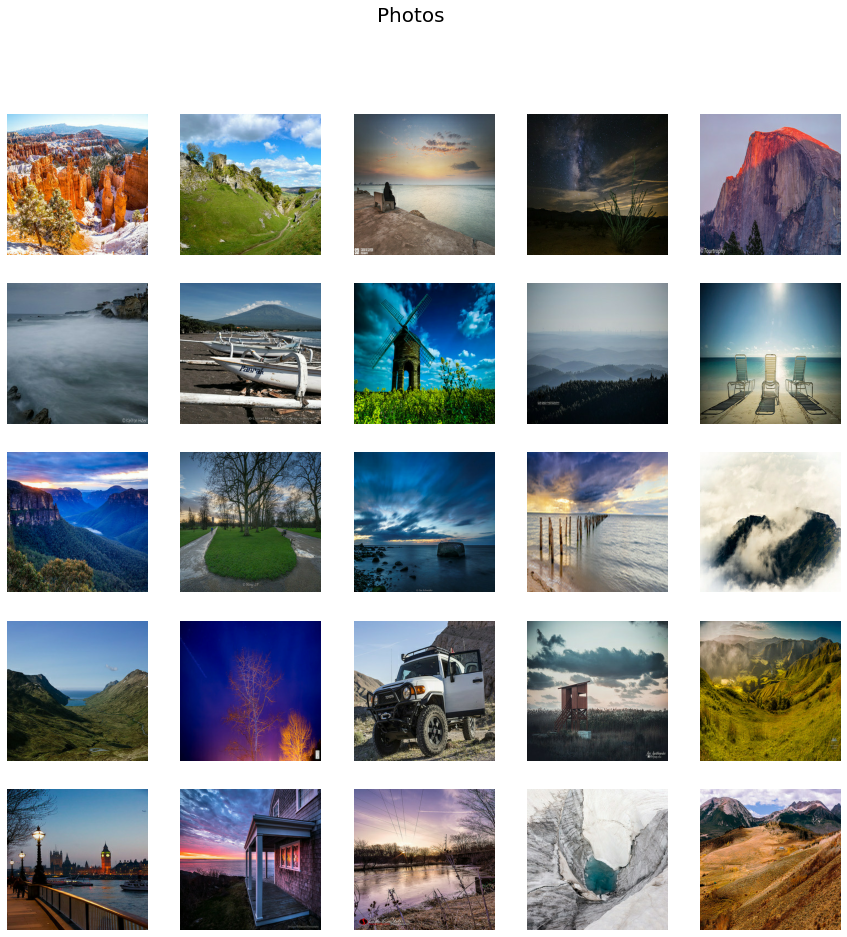

In [10]:
display_samples(photo_ds,5,5,title='Photos')

## Inspect some color histograms
It is said that Monet had a preference for certain colors (blue and yellow), and this could show a trend in color histograms. Such feature can be exploited for image classification, but this is not the current task. See [this work](https://www.kaggle.com/code/isaienkov/monet-masterpieces-eda-and-image-classification).

In [11]:
def display_samples_with_color_histograms(ds, num_sample_img=3, title='samples with histograms', randomize = True, bin_size = None):
    # Display an array of images from dataset
    # ds is of type: tensorflow.python.data.ops.dataset_ops.BatchDataset (RGB)
    if randomize:
        ds_iter =iter(ds.shuffle(buffer_size=1000)) # random sample
    else:
        ds_iter =iter(ds) # random sample
    fig, ax = plt.subplots(num_sample_img, 2, figsize=(15, int(15*num_sample_img/2)))
    if bin_size is None:
        bin_size = 256
    for j in range(num_sample_img):
        example_sample = next(ds_iter)
        
        # Plot the image
        ax[j, 0].axis('off')
        ax[j, 0].imshow(example_sample[0] * 0.5 + 0.5)
        ax[j,0].set_title('image')

        # Create color histograms for each channel
        hist_r = ax[j, 1].hist(example_sample[0, :, :, 0].numpy().ravel(), bins=bin_size, color='red', alpha=0.5)
        hist_g = ax[j, 1].hist(example_sample[0, :, :, 1].numpy().ravel(), bins=bin_size, color='green', alpha=0.5)
        hist_b = ax[j, 1].hist(example_sample[0, :, :, 2].numpy().ravel(), bins=bin_size, color='blue', alpha=0.5)
        ax[j,1].set_title('color histogram')
    plt.suptitle(title, size=20)
    plt.show()

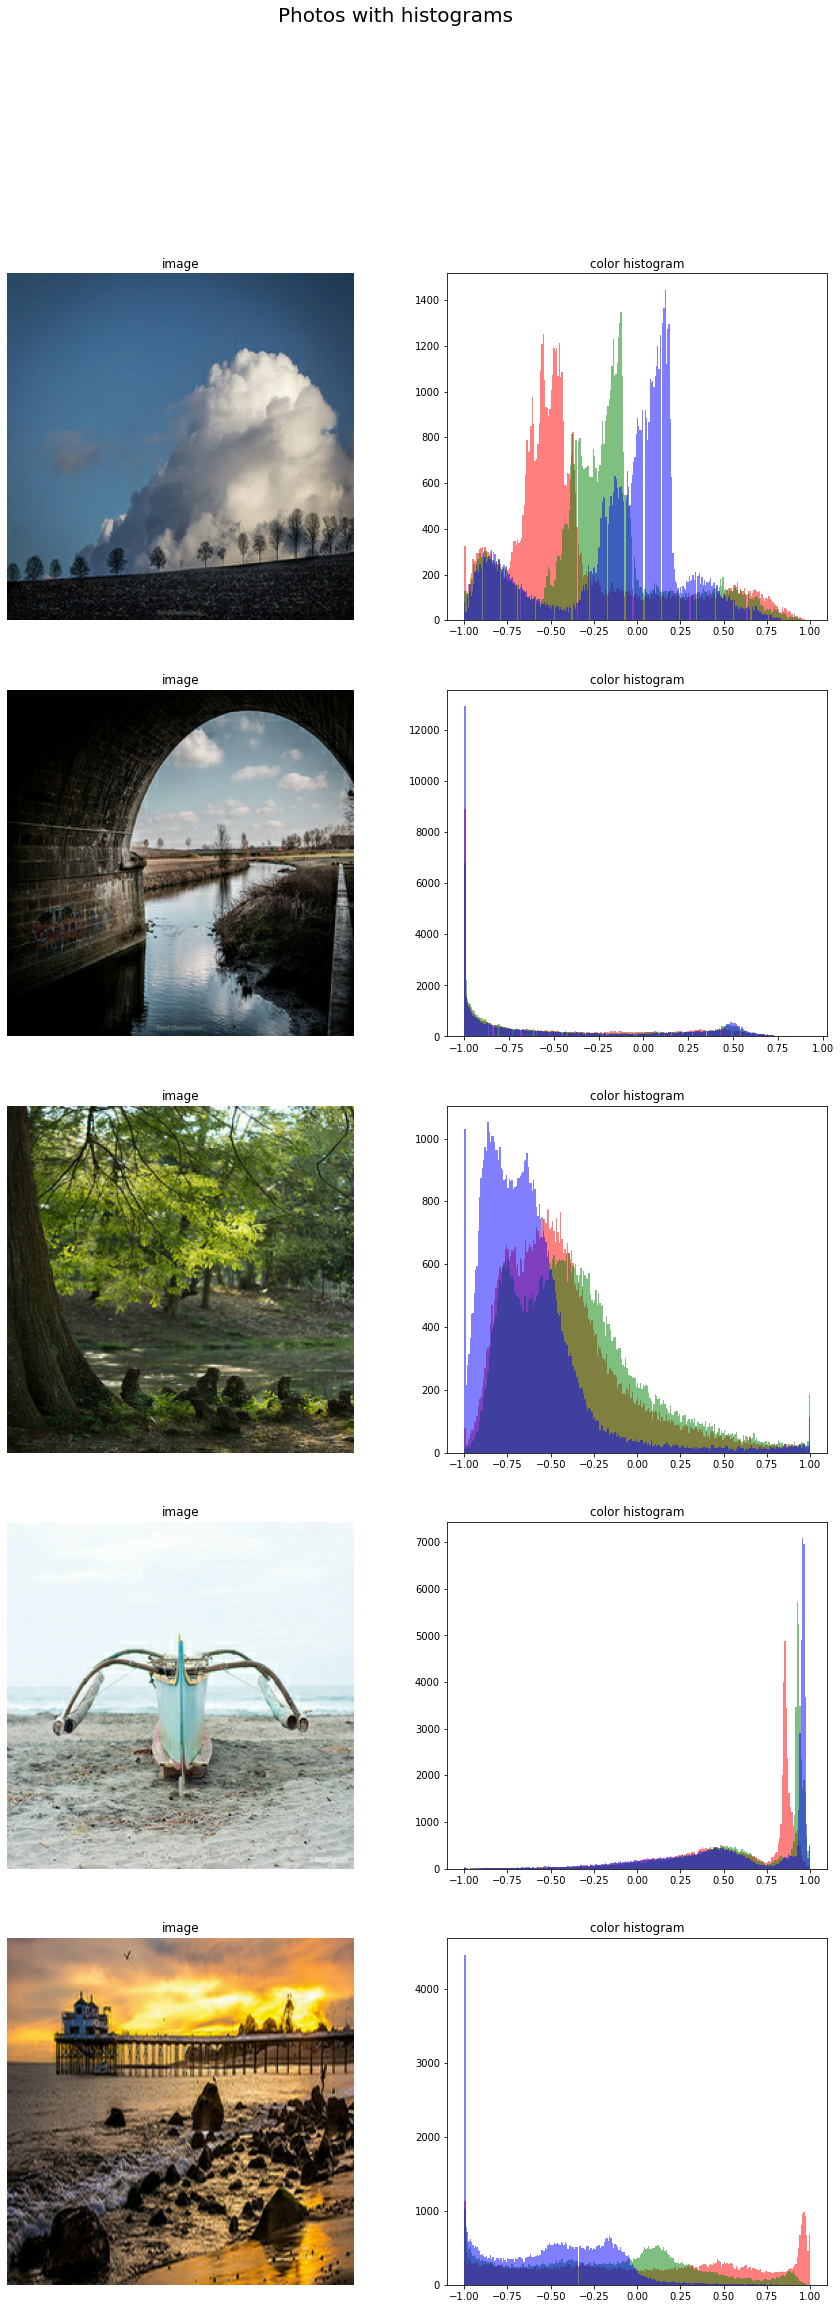

In [12]:
display_samples_with_color_histograms(photo_ds,5,title='Photos with histograms', randomize=False)

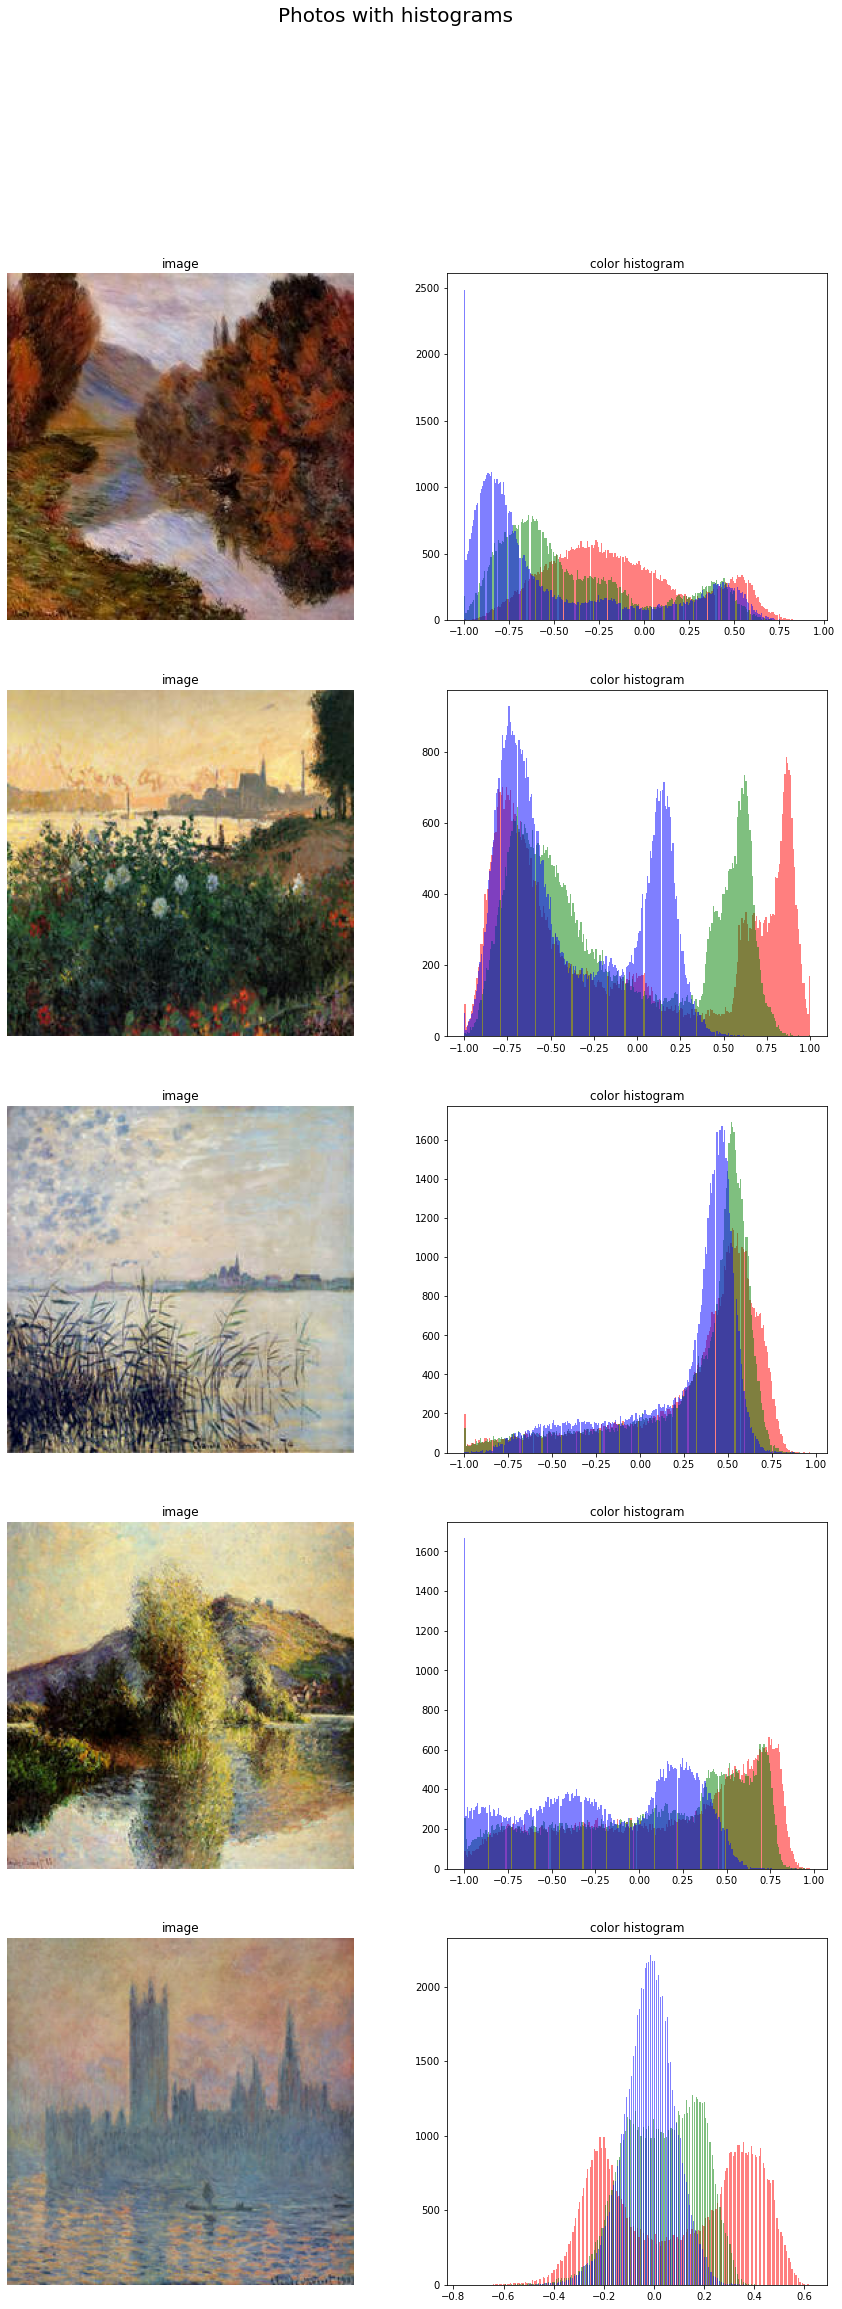

In [13]:
display_samples_with_color_histograms(monet_ds,5,title='Photos with histograms')

Average image colors:

In [14]:
def compute_average_color_channels(ds,ds_len):
    """Computes the average value of red, green and blue channels for all images in the dataset.

    Args:
        ds: A tf.data.Dataset object that contains the images.

    Returns:
        A tuple of three floats, the average value of the RGB channels.
    """

    # Initialize the average values for the red, green and blue channels
    red_avg = 0.0
    green_avg = 0.0
    blue_avg = 0.0

    # Iterate over all images in the dataset
    for image in ds:
        # Get the blue, red and green channels of the image
        red = image[0, :, :, 0]
        green = image[0, :, :, 1]
        blue = image[0, :, :, 2]

        # Add the blue, red and green channels to the running average
        red_avg += red
        green_avg += green
        blue_avg += blue       

    # Divide the running average by the number of images
    red_avg /= ds_len
    green_avg /= ds_len
    blue_avg /= ds_len
    

    return red_avg, green_avg, blue_avg

In [15]:
avg_color_photo = compute_average_color_channels(photo_ds,len_photo)
avg_color_monet = compute_average_color_channels(monet_ds,len_monet)

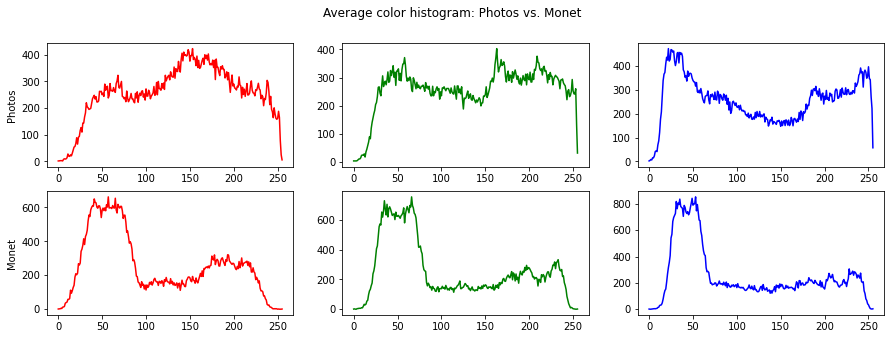

In [16]:
# Plot the average histogram at the end
fig, ax = plt.subplots(2, 3, figsize=(15, 5))
ax[0,0].plot(np.histogram(avg_color_photo[0], bins=256)[0],color='red')
ax[0,1].plot(np.histogram(avg_color_photo[1], bins=256)[0],color='green')
ax[0,2].plot(np.histogram(avg_color_photo[2], bins=256)[0],color='blue')
ax[1,0].plot(np.histogram(avg_color_monet[0], bins=256)[0],color='red')
ax[1,1].plot(np.histogram(avg_color_monet[1], bins=256)[0],color='green')
ax[1,2].plot(np.histogram(avg_color_monet[2], bins=256)[0],color='blue')
plt.suptitle('Average color histogram: Photos vs. Monet')
ax[0,0].set_ylabel('Photos')
ax[1,0].set_ylabel('Monet')
plt.show()

In [17]:
print('The average colors for photos are:')
print(' Photos:\n  blue: {:.2f}\n  green: {:.2f}\n  red:{:.2f}'.format(*[np.mean(x) for x in avg_color_photo]))

print('The average colors for Monet paintings are:')
print(' Monet:\n  blue: {:.2f}\n  green: {:.2f}\n  red:{:.2f}'.format(*[np.mean(x) for x in avg_color_monet]))

The average colors for photos are:
 Photos:
  blue: -0.19
  green: -0.18
  red:-0.23
The average colors for Monet paintings are:
 Monet:
  blue: 0.04
  green: 0.05
  red:-0.05


These histograms show that Monet paintings in the dataset are darker than photos. The relative brightness of color is similar for photos, whileas Monet images contain less red than green and blue lights.

<a id='section3'></a>

# 3. Model Building and Training

Our CycleGan model needs 2 generators and 2 discriminators.


In [18]:
def plot_my_model(model,figsize=(12,12)):
    fig, ax = plt.subplots(figsize=figsize)
    print('Displaying', model.name)
    img_name = model.name + '_plot.png'
    plot_model(model,
               to_file = img_name,
               show_shapes=True,
               show_layer_names=True)
    img = plt.imread(img_name)
    ax.imshow(img)
    ax.axis('off')
    plt.show()

# Build the generator

## Reflection Padding
Add reflection padding in generator to avoid some white borders.

Keras only supports zero padding. The reference for reflection padding is [here](https://www.machinecurve.com/index.php/2020/02/10/using-constant-padding-reflection-padding-and-replication-padding-with-keras/#keras-reflectionpadding2d).

In [19]:
from tensorflow import pad

'''
  2D Reflection Padding
  Attributes:
    - padding: (padding_width, padding_height) tuple
'''
class ReflectionPadding2D(layers.Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1] + 2 * self.padding[0], input_shape[2] + 2 * self.padding[1], input_shape[3])

    def call(self, input_tensor, mask=None):
        padding_width, padding_height = self.padding
        return pad(input_tensor, [[0,0], [padding_height, padding_height], [padding_width, padding_width], [0,0] ], 'REFLECT')

In [20]:
def Generator(n_blocks=9):
    
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    
    inputs = layers.Input(shape=[256,256,3])
    x = inputs

    # c7s1-64
    x = ReflectionPadding2D(padding=(3, 3))(x)
    x = layers.Conv2D(64, 7, kernel_initializer=initializer, use_bias=False)(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(x)
    x = layers.ReLU()(x)
    
    # d128
    x = layers.Conv2D(128, 3, strides=2, padding='same', kernel_initializer=initializer, use_bias=False)(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(x)
    x = layers.ReLU()(x)
    
    # d256
    x = layers.Conv2D(256, 3, strides=2, padding='same', kernel_initializer=initializer, use_bias=False)(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(x)
    x = layers.ReLU()(x)
    
    # R256
    for i in range(n_blocks):
        skip = x
        x = ReflectionPadding2D(padding=(1, 1))(x)
        x = layers.Conv2D(256, 3, kernel_initializer=initializer, use_bias=False)(x)
        x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(x)
        x = layers.ReLU()(x)
        
        x = ReflectionPadding2D(padding=(1, 1))(x)
        x = layers.Conv2D(256, 3, kernel_initializer=initializer, use_bias=False)(x)
        x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(x)
        
        x = layers.Add()([x, skip])
    
    # u128
    x = layers.Conv2DTranspose(128, 3, strides=2, padding='same', kernel_initializer=initializer, use_bias=False)(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(x)
    x = layers.ReLU()(x)
    
    # u64
    x = layers.Conv2DTranspose(64, 3, strides=2, padding='same', kernel_initializer=initializer, use_bias=False)(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(x)
    x = layers.ReLU()(x)
    
    # c7s1-3
    x = ReflectionPadding2D(padding=(3, 3))(x)
    x = layers.Conv2D(3, 7, kernel_initializer=initializer, activation='tanh')(x)

    return keras.Model(inputs=inputs, outputs=x)

# Build the discriminator

The discriminator takes in the input image and classifies it as real or fake (generated). Instead of outputing a single node, the discriminator outputs a smaller 2D image with higher pixel values indicating a real classification and lower values indicating a fake classification.

In [21]:
def Discriminator():
    
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    
    inputs = layers.Input(shape=[256,256,3])
    x = inputs
    
    # C64
    x = layers.Conv2D(64, 4, strides=2, padding='same', kernel_initializer=initializer, use_bias=False)(x)
    x = layers.LeakyReLU(0.2)(x)
    
    # C128
    x = layers.Conv2D(128, 4, strides=2, padding='same', kernel_initializer=initializer, use_bias=False)(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(x)
    x = layers.LeakyReLU(0.2)(x)
    
    # C256
    x = layers.Conv2D(256, 4, strides=2, padding='same', kernel_initializer=initializer, use_bias=False)(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(x)
    x = layers.LeakyReLU(0.2)(x)

    # C512
    x = layers.ZeroPadding2D()(x)
    x = layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(x)
    x = layers.LeakyReLU(0.2)(x)
    
    x = layers.ZeroPadding2D()(x)
    x = layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [22]:
with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

Monet generator
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
reflection_padding2d (Reflectio (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 9408        reflection_padding2d[0][0]       
__________________________________________________________________________________________________
instance_normalization (Instanc (None, 256, 256, 64) 128         conv2d[0][0]                     
______________________________________________________________________________

None

Displaying model


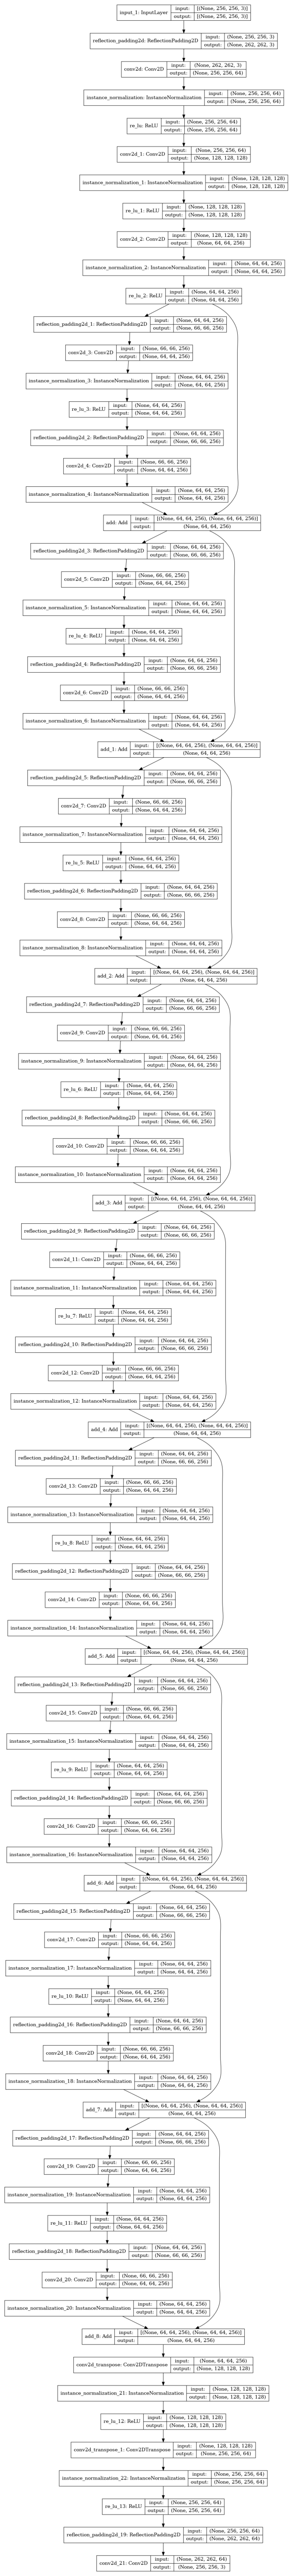

In [23]:
print('Monet generator')
display(monet_generator.summary())
plot_my_model(monet_generator,figsize=(20,100))

In [24]:
print('Monet discriminator')
display(monet_discriminator.summary())
plot_my_model(monet_discriminator,figsize=(10,25))

Monet discriminator
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 128, 128, 64)      3072      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 64, 64, 128)       131072    
_________________________________________________________________
instance_normalization_46 (I (None, 64, 64, 128)       256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 32,

None

Displaying model_2


**Remark**

Notice we have over 11 million trainable paramters in each generator and over 3 million trainable parameters in each discriminator.

Since our generators are not trained yet, the generated Monet-esque photo does not show what is expected at this point.

In [25]:
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

to_monet = monet_generator(example_photo)

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet-esque Photo")
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.show()

# Build the CycleGAN model

We will subclass a `tf.keras.Model` so that we can run `fit()` later to train our model. During the training step, the model transforms a photo to a Monet painting and then back to a photo. The difference between the original photo and the twice-transformed photo is the cycle-consistency loss. We want the original photo and the twice-transformed photo to be similar to one another.

The losses are defined in the next section.

In [26]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

# Define loss functions

In [27]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)
        total_disc_loss = real_loss + generated_loss
        return total_disc_loss * 0.5
    
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)
    
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
        return LAMBDA * loss1
    
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

# Train the CycleGAN

Let's compile our model. Since we used `tf.keras.Model` to build our CycleGAN, we can just ude the `fit` function to train our model.

In [28]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [29]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=45 # EDIT HERE FOR MORE ITERATIONS AT WILL
)

Epoch 1/45
300/300 [==============================] - 186s 399ms/step - monet_gen_loss: 9.2671 - photo_gen_loss: 9.3396 - monet_disc_loss: 0.3996 - photo_disc_loss: 0.4306
Epoch 2/45
300/300 [==============================] - 121s 402ms/step - monet_gen_loss: 8.2482 - photo_gen_loss: 8.6302 - monet_disc_loss: 0.6209 - photo_disc_loss: 0.5009
Epoch 3/45
300/300 [==============================] - 122s 402ms/step - monet_gen_loss: 7.4791 - photo_gen_loss: 7.9402 - monet_disc_loss: 0.6427 - photo_disc_loss: 0.5732
Epoch 4/45
300/300 [==============================] - 121s 402ms/step - monet_gen_loss: 7.0652 - photo_gen_loss: 7.4143 - monet_disc_loss: 0.6110 - photo_disc_loss: 0.5237
Epoch 5/45
300/300 [==============================] - 121s 401ms/step - monet_gen_loss: 6.8846 - photo_gen_loss: 7.2728 - monet_disc_loss: 0.6106 - photo_disc_loss: 0.5182
Epoch 6/45
300/300 [==============================] - 121s 400ms/step - monet_gen_loss: 6.6210 - photo_gen_loss: 6.9570 - monet_disc_loss: 0

# Visualize Monet-esque photos producted by the model after training

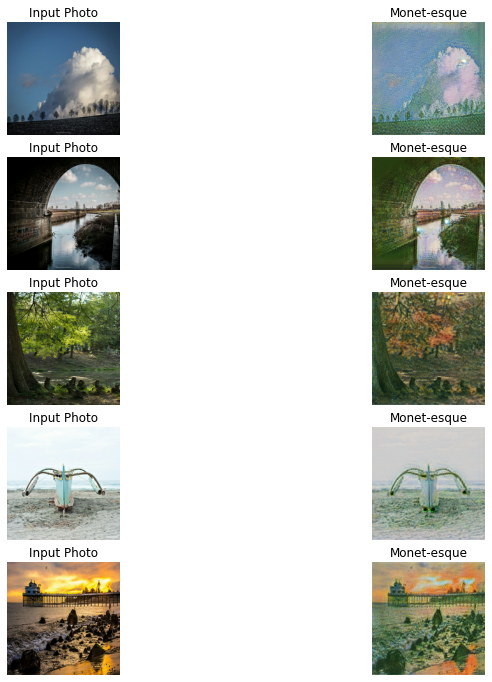

In [30]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.savefig('first_monetesque_image.png', dpi=200)
plt.show()

# Save weights
https://www.kaggle.com/amyjang/monet-cyclegan-tutorial/comments#1195949

In [31]:
with strategy.scope():
    monet_generator.save_weights('./monet_generator_wr_00.h5')
    photo_generator.save_weights('./photo_generator_wr_00.h5')
    
    monet_discriminator.save_weights('./monet_discriminator_wr_00.h5')
    photo_discriminator.save_weights('./photo_discriminator_wr_00.h5')

# Re-train with loaded weights for decaying learing rate

In [32]:
with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos
    
    monet_generator.load_weights('./monet_generator_wr_00.h5')
    photo_generator.load_weights('./photo_generator_wr_00.h5')
    
    monet_discriminator.load_weights('./monet_discriminator_wr_00.h5')
    photo_discriminator.load_weights('./photo_discriminator_wr_00.h5')

In [33]:
with strategy.scope():
    lr_fn = tf.keras.optimizers.schedules.PolynomialDecay(
        initial_learning_rate=2e-4,
        decay_steps=100*300,    # 100 epoch with 300 step
        end_learning_rate=0
    )

    monet_generator_optimizer = tf.keras.optimizers.Adam(beta_1=0.5, learning_rate=lr_fn)
    photo_generator_optimizer = tf.keras.optimizers.Adam(beta_1=0.5, learning_rate=lr_fn)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(beta_1=0.5, learning_rate=lr_fn)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(beta_1=0.5, learning_rate=lr_fn)

    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )
    
    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=80
)

Epoch 1/80
300/300 [==============================] - 183s 400ms/step - monet_gen_loss: 5.0690 - photo_gen_loss: 4.9250 - monet_disc_loss: 0.5908 - photo_disc_loss: 0.5702
Epoch 2/80
300/300 [==============================] - 121s 400ms/step - monet_gen_loss: 5.0436 - photo_gen_loss: 4.8941 - monet_disc_loss: 0.5957 - photo_disc_loss: 0.5690
Epoch 3/80
300/300 [==============================] - 122s 403ms/step - monet_gen_loss: 4.9585 - photo_gen_loss: 4.8081 - monet_disc_loss: 0.5789 - photo_disc_loss: 0.5701
Epoch 4/80
300/300 [==============================] - 121s 399ms/step - monet_gen_loss: 4.9658 - photo_gen_loss: 4.8320 - monet_disc_loss: 0.5791 - photo_disc_loss: 0.5615
Epoch 5/80
300/300 [==============================] - 121s 400ms/step - monet_gen_loss: 4.9863 - photo_gen_loss: 4.8280 - monet_disc_loss: 0.5802 - photo_disc_loss: 0.5696
Epoch 6/80
300/300 [==============================] - 121s 402ms/step - monet_gen_loss: 4.9937 - photo_gen_loss: 4.8268 - monet_disc_loss: 0

<a id='section4'></a>

# 4. Result

# Visualize final Monet-esque photos

In [34]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.savefig('final_monetesque_image.png', dpi=200)
plt.show()

# Create submission file

In [35]:
import PIL
! mkdir ../images

In [36]:
i = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

In [37]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'

<a id='section5'></a>

# 5. Conclusions

* Cycle GAN is able to perform style transfer without using paired image datasets. In doing so, our model uses over 28 million trainable parameters, which need to be carefully tuned.
* Such a a large model models must use GPUs or TPUs for training. However, kaggle limits these resources, which makes it hard for learners to experiment because one soon runs out of credits.  Moving the model to colab did not work for me, as it was even slower and prone to collapse.
* This model can get better with more iterations, but there is a 300 minutes time limit for the competition.
* FID (Fréchet Inception Distance (FID)) can measure how similar two image datasets are by computing a statistic in the activations of an inception neural network. This is a clever way to check if the generated samples are similar to the target images without making direct copies.
* MiFID, or Memorization-informed FID penalizes generators that produce very similar images. In doing so, the competition score will penalize GANs that had a training issue known as mode collapse, i.e.,a GAN where all the generated images converge to one single image able to fool the discriminator.